In [1]:
from pathlib import Path
from tensorflow.python.keras.callbacks import EarlyStopping
%matplotlib inline
import pandas as pd
from imutils import build_montages
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pprint import pprint
import os

from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
import keras.backend as K
import matplotlib.pyplot as plt

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


# load/preprocess images

In [2]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [3]:
paths_all_labels = []
for image in images:
    x = image.split("d", 1)
    paths_all_labels.append((x[0], './frgc32x32/'+image))

In [4]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [5]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


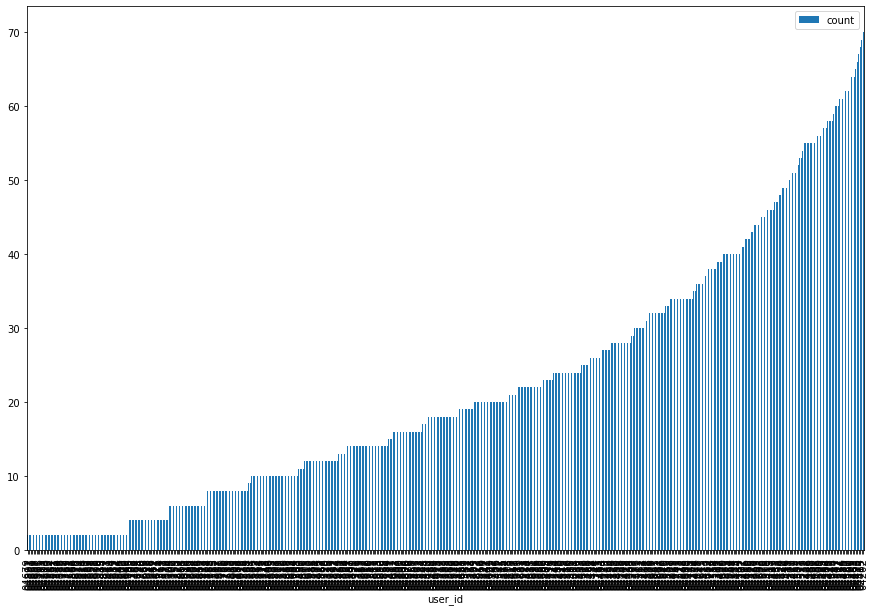

In [6]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [10]:
data_size = 20

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)
ids_to_keep = ids_to_keep[ids_to_keep].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(data_size)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

There are 265/568 (46.65%) unique IDs remaining.


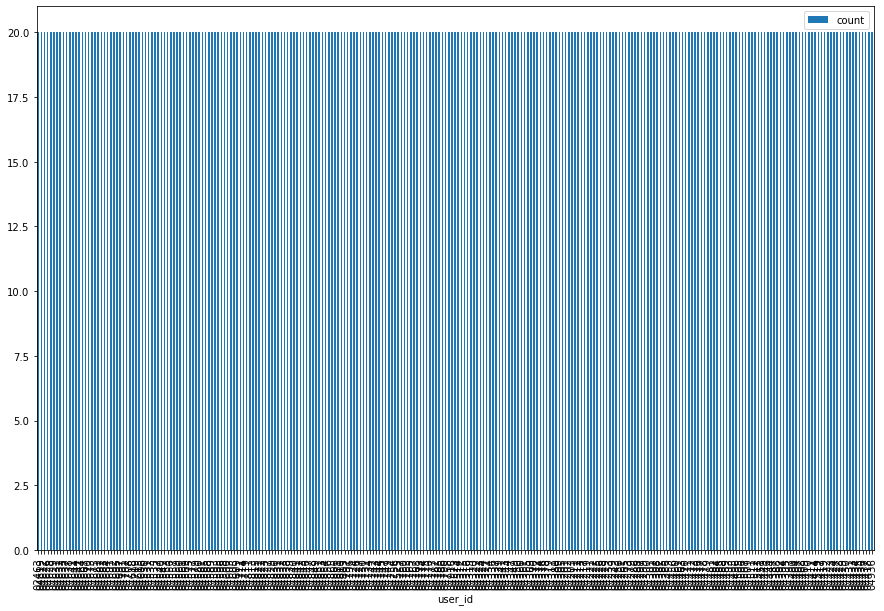

In [11]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [12]:
subset_directory_df.head()
subset_directory_df_sorted = subset_directory_df.sort_values(by=['path'])

In [13]:
def load_images():
    _labels = []

    items = []
    for _, row in tqdm(subset_directory_df_sorted.iterrows(), desc='loading images'):
        img = cv2.imread(row['path'], 0)
        img = cv2.resize(img, (32, 32))
        if row['user_id'] not in _labels:
            _labels.append(row['user_id'])
        lbl = _labels.index(row['user_id'])
        items.append((img, lbl))
    return items

items = load_images()

In [14]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    numClasses = new_unique

    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)

In [15]:
train_test_split = 0.7
split = int(train_test_split * new_unique) * 20

with open ('identities.txt', 'w+') as f:
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][:split]]) + '\n')
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][split:]]) + '\n')

trainX = np.array([x[0] for x in items[:split]])
trainY = np.array([x[1] for x in items[:split]])

testX = np.array([x[0] for x in items[split:]])
testY = np.array([x[1] for x in items[split:]])

trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)




# build model

In [23]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
EPOCHS = 100

In [24]:
def build_model_20(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(48, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_20')

    return model


In [25]:
def build_model_60(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_60')

    return model

In [26]:
def build_model_130(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(80, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_130')

    return model

In [27]:
def build_model_250(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_250')

    return model

In [28]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
    featsA = vectors[0]
    featsB = vectors[1]
	# compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
	# return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [22]:
def train_model(model_fun, save_name, train = True):
    print(f'Training model: {save_name}')

    base_out = 'output'
    model_path = os.path.sep.join([base_out, f'model_{save_name}'])
    plot_path = os.path.sep.join([base_out, f'plot_{save_name}.png'])

    imgA = Input(shape=IMG_SHAPE)
    imgB = Input(shape=IMG_SHAPE)
    featureExtractor = model_fun(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[imgA, imgB], outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer="adam",
	    metrics=["accuracy"])

    print(model.summary())

    if not train:
        return

    history = model.fit(
        [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS)

    model.save(model_path)
    plot_training(history, plot_path)

Training model: sn_20
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
model_20 (Functional)           (None, 48)           23616       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model_2

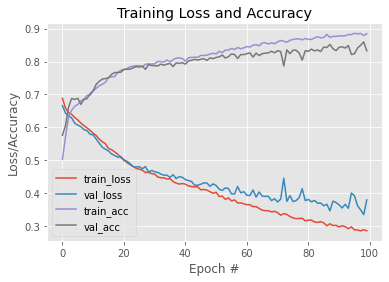

In [29]:
train = True
train_model(build_model_20, 'sn_20', train)
# train_model(build_model_60, 'sn_60', train)
# train_model(build_model_130, 'sn_130', train)
# train_model(build_model_250, 'sn_250', train)

# Convert to TensorFlow Lite

In [16]:



def convert_model(model_path, output_model):
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()
    open(output_model, "wb").write(tflite_model)


def interpret_model(tflite_model, pairTest):
        
    interpreter = tf.lite.Interpreter(model_path=tflite_model)
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Resize interpreter to match correct size of input
    interpreter.resize_tensor_input(input_details[0]['index'], (3200, 32, 32, 1))
    interpreter.resize_tensor_input(input_details[1]['index'], (3200, 32, 32, 1))

    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    pairTest = pairTest.astype('float32')
    interpreter.set_tensor(input_details[0]['index'], pairTest[:,0])
    interpreter.set_tensor(input_details[1]['index'], pairTest[:,1])

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data


Accuracy 0.870625
Recall 0.81576145


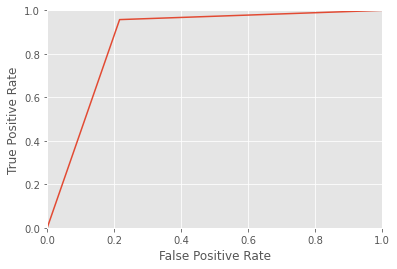

In [255]:

from sklearn.metrics import roc_curve,roc_auc_score


def model_metrics(labels, predictions):
    m = tf.keras.metrics.Accuracy()
    m.update_state(labels, predictions)
    print("Accuracy", m.result().numpy())
    
    fpr , tpr , thresholds = roc_curve(labels, predictions)
    plot_roc_curve (fpr,tpr) 


def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    



-----TensorFlow Lite----
Accuracy 0.870625
Recall 0.81576145


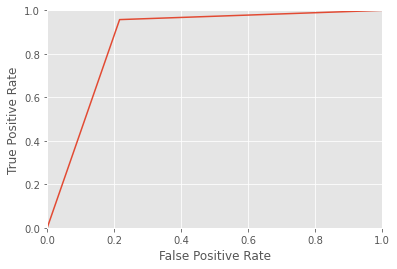

-----TensorFlow----
Accuracy 0.870625
Recall 0.81576145


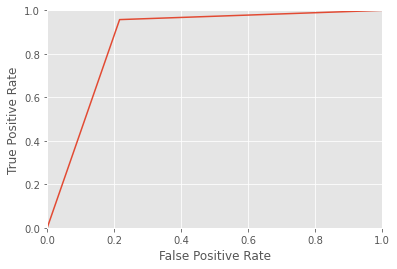

In [257]:
  
# TensorFlow Lite
output_model = ['.\output\converted_model20.tflite', '.\output\converted_model60.tflite', '.\output\converted_model130.tflite','.\output\converted_model250.tflite' ]

saved_models = [".\output\models\model_sn_20", ".\output\models\model_sn_60", ".\output\models\model_sn_130", ".\output\models\model_sn_250"]


print("-----TensorFlow Lite----")
for i in 
convert_model(saved_model_dir, output_model)
output_data = interpret_model(output_model, pairTest)

# Choose closest integer
predictions = np.rint(output_data)
model_metrics(labels, predictions)


# TensorFlow
print("-----TensorFlow----")
model = load_model(saved_model_dir)
preds = model.predict([pairTest[:, 0], pairTest[:, 1]])

predictions = np.rint(output_data)

model_metrics(labelTest, predictions)